In [2]:
import numpy as np
import random
import time
from matplotlib import pyplot as plt
import random
import ipympl


In [3]:
def demand(p1,p2):
        if p1 < p2:
            d = 1 - p1
        elif p1 == p2:
            d = 0.5 * (1 - p1)
        else:
            d = 0
        return d

In [4]:
def player3(prices, Q, epsilon, prev):
    if random.uniform(0,1) < epsilon:
        p3 = np.random.choice(len(prices))
        #print('now its random', epsilon)
    else:
        #p3, pyt = np.unravel_index(np.argmax(Q),Q.shape)
        p3 = np.argmax(Q[:,prev[1,1]])
    return p3

In [5]:
def player4(prices, Q, epsilon, prev):
    if random.uniform(0,1) < epsilon:
        p4 = np.random.choice(len(prices))
        #print('now its random', epsilon)
    else:
        p4 = np.argmax(Q[:,prev[0,1]])
    return p4

In [6]:
def update(Q, prev, alpha, delta, prices, indic):
    if indic == 1: 
        p1 = prices[prev[0,0]]
        p2 = prices[prev[1,0]]
        p22 = prices[prev[1,1]]
        pe = Q[prev[0,0],prev[1,0]]
        ne = p1*demand(p1,p2) + delta* p1*demand(p1,p22) + delta**2 * Q[np.argmax(Q[:,prev[1,1]]),prev[1,1]]
        Q[prev[0,0], prev[1,0]] = (1-alpha) * pe + alpha * ne
    else: 
        p1 = prices[prev[1,0]]
        p2 = prices[prev[0,0]]
        p22 = prices[prev[0,1]]
        pe = Q[prev[1,0],prev[0,0]]
        ne = p1*demand(p1,p2) + delta* p1*demand(p1,p22) + delta**2 * Q[np.argmax(Q[:,prev[0,1]]),prev[0,1]]
        Q[prev[1,0], prev[0,0]] = (1-alpha) * pe + alpha * ne

In [7]:
def profit(pris1, pris2):
    return pris1*demand(pris1,pris2)


In [8]:
def game(prices, periods, alpha, theta):
    a = len(prices)
    Q_table = np.zeros((a, a))
    Q_table2 = np.zeros((a, a))
    profitability = 0.0
    optimality = 0.0
    print('CHECK', int(periods/2)-1)
    p_ipriser =np.zeros(int(periods/2)-1)
    p_jpriser =np.zeros(int(periods/2)-1)
    prev_p = np.zeros((2,2), dtype=int)
    for i in range(1):
        for j in range(1):
            prev_p[i,j] = np.random.choice(len(prices))
    t = 3
    i_counter = 0
    j_counter = 0
    for t in range(t, periods+1):
        epsilon = (1-theta)**t
        
        if t % 2 != 0: 
            update(Q_table, prev_p, alpha, 0.95, prices,1)
            p_i = player3(prices, Q_table, epsilon, prev_p)
            prev_p[0,0] = prev_p[0,1]
            prev_p[0,1] = p_i
            prev_p[1,0] = prev_p[1,1]
            p_ipriser[i_counter] = (prices[p_i])
            i_counter += 1
            #print('Spiller 1 tur: p:', prices[p_i],' p_j: ', prices[prev_p[1,1]],'iteration:', t,'Q_table: \n', Q_table)
            profitability += profit(prices[p_i],prices[prev_p[1,1]] ) 
            
        else: 
            update(Q_table2, prev_p, alpha, 0.95, prices, 0)
            p_j = player4(prices, Q_table2, epsilon, prev_p)
            prev_p[1,0] = prev_p[1,1]
            prev_p[1,1] = p_j
            prev_p[0,0] = prev_p[0,1]
            p_jpriser[j_counter] = (prices[p_j])
            j_counter += 1
            #print('Spiller 2 tur: p:', prices[p_j], 'p_i', prices[prev_p[0,1]],' iteration: ', t,'Q_table2: \n', Q_table2)
            profitability += profit(prices[prev_p[0,1]],prices[p_j] )
    return (1/periods)*profitability, p_ipriser, p_jpriser

In [9]:
x = [0, 1/6, 2/6, 3/6, 4/6, 5/6, 1]

SyntaxError: invalid syntax (2485743006.py, line 1)

In [14]:
%matplotlib widget

CHECK 4999


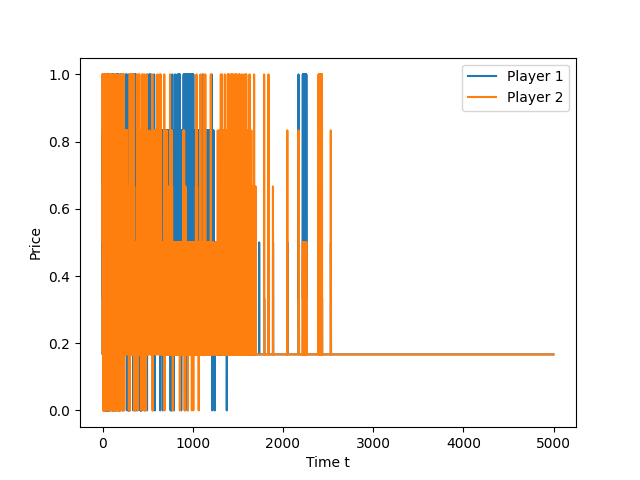

In [15]:

pro, arr, arr1 = game( x, 10000, 0.3, 0.00138)
t_arr = np.arange(4999)

plt.plot(t_arr,arr,label='Player 1')
plt.plot(t_arr,arr1, label='Player 2')
plt.xlabel("Time t")
plt.ylabel("Price")
plt.legend()
plt.show()